In [2]:
from pyspark import SparkContext,SparkConf,StorageLevel
from pyspark.sql import SQLContext
from pyspark.sql import HiveContext,SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pandas import Series,DataFrame
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.cluster import DBSCAN
import seaborn as sns
import numpy as np

# 导入数据

In [3]:
spark = SparkSession.builder.enableHiveSupport().getOrCreate()
df = spark.read.csv(r"C:\Users\钟冠霆\Desktop\NGC2266.csv", encoding='gbk', header=True, inferSchema=True) # header表示数据的第一行是否为列名，inferSchema表示自动推断schema,此时未指定schema

df.printSchema()

root
 |-- solution_id: long (nullable = true)
 |-- designation: string (nullable = true)
 |-- source_id: long (nullable = true)
 |-- random_index: integer (nullable = true)
 |-- ref_epoch: integer (nullable = true)
 |-- ra: double (nullable = true)
 |-- ra_error: double (nullable = true)
 |-- dec: double (nullable = true)
 |-- dec_error: double (nullable = true)
 |-- parallax: double (nullable = true)
 |-- parallax_error: double (nullable = true)
 |-- parallax_over_error: double (nullable = true)
 |-- pm: double (nullable = true)
 |-- pmra: double (nullable = true)
 |-- pmra_error: double (nullable = true)
 |-- pmdec: double (nullable = true)
 |-- pmdec_error: double (nullable = true)
 |-- ra_dec_corr: double (nullable = true)
 |-- ra_parallax_corr: double (nullable = true)
 |-- ra_pmra_corr: double (nullable = true)
 |-- ra_pmdec_corr: double (nullable = true)
 |-- dec_parallax_corr: double (nullable = true)
 |-- dec_pmra_corr: double (nullable = true)
 |-- dec_pmdec_corr: double (nul

In [4]:
df.head()

Row(solution_id=1636042515805110273, designation='Gaia EDR3 3384969519614205696', source_id=3384969519614205696, random_index=920207798, ref_epoch=2016, ra=100.78637909852603, ra_error=0.22954163, dec=26.66998979501042, dec_error=0.20330644, parallax=-0.03856706348566343, parallax_error=0.2564998, parallax_over_error=-0.15035905, pm=0.21122828, pmra=-0.011967379136214006, pmra_error=0.280357, pmdec=-0.21088899894688734, pmdec_error=0.21504003, ra_dec_corr=-0.1615939, ra_parallax_corr=-0.07412865, ra_pmra_corr=-0.2184471, ra_pmdec_corr=0.2168218, dec_parallax_corr=-0.14925535, dec_pmra_corr=0.13450682, dec_pmdec_corr=-0.33642387, parallax_pmra_corr=0.32979706, parallax_pmdec_corr=-0.16170643, pmra_pmdec_corr=-0.07496941, astrometric_n_obs_al=209, astrometric_n_obs_ac=0, astrometric_n_good_obs_al=209, astrometric_n_bad_obs_al=0, astrometric_gof_al=-0.374153, astrometric_chi2_al=204.33873, astrometric_excess_noise=0.0, astrometric_excess_noise_sig=0.0, astrometric_params_solved=31, astrom

# 数据处理

## 筛选数据

In [5]:
input_cols = ["ra", "dec", "parallax", "pmra", "pmdec","ra_error","dec_error","parallax_error","pmra_error","pmdec_error"]
df = df.select(input_cols)

In [6]:
df.printSchema()

root
 |-- ra: double (nullable = true)
 |-- dec: double (nullable = true)
 |-- parallax: double (nullable = true)
 |-- pmra: double (nullable = true)
 |-- pmdec: double (nullable = true)
 |-- ra_error: double (nullable = true)
 |-- dec_error: double (nullable = true)
 |-- parallax_error: double (nullable = true)
 |-- pmra_error: double (nullable = true)
 |-- pmdec_error: double (nullable = true)



## 选取误差小于1的数据

In [7]:
df = df[(df['ra_error']<1) & (df['dec_error']<1) & (df['parallax_error']<1) & (df['pmra_error']<1) & (df['pmdec_error']<1)]

## 去除空数据

In [8]:
df = df.dropna()

In [9]:
df.count()

6763

## 保存处理后的数据

In [35]:
df.repartition(1).write.csv(r"C:\Users\钟冠霆\Desktop\data.csv", encoding="utf-8", header=True)

# 特征工程

## 标准化处理

In [10]:
transfer = StandardScaler()

In [11]:
data_cols = ["ra", "dec", "parallax", "pmra", "pmdec"]
df = df.select(data_cols)

In [12]:
df.show()

+------------------+------------------+--------------------+--------------------+--------------------+
|                ra|               dec|            parallax|                pmra|               pmdec|
+------------------+------------------+--------------------+--------------------+--------------------+
|100.78637909852603| 26.66998979501042|-0.03856706348566343|-0.01196737913621...|-0.21088899894688734|
|100.80907272449686| 26.66959716009105|  0.2786819366002739|  0.7481387895024987| -3.0488370712268043|
|100.82199364094816| 26.66957026381139|  0.6581558996068628| -1.4534606732761723| -1.9352983649657824|
|100.82430116989943| 26.67615214550474| 0.33016490904520024|  0.3337060620286505| -0.9115421424931293|
|100.82710117995556| 26.67756358354643| 0.36054497055871737|-0.31195775660619907| -0.9387403499440237|
|100.82556127699638| 26.67197819417349| 0.29315490965257324| -1.3185872189717616| -1.2716261294616231|
|100.81615901664189|  26.6712715786796|  0.5597144103698711|  0.762522409

In [13]:
df = df.toPandas()

In [14]:
df.shape

(6763, 5)

In [15]:
df = transfer.fit_transform(df)

In [16]:
df

array([[ 0.13135738, -2.04077048, -0.6534969 , -0.05129517,  0.57259671],
       [ 0.26925771, -2.04346964, -0.2361527 ,  0.17983099, -0.02079163],
       [ 0.34777308, -2.04365454,  0.26304905, -0.48961131,  0.21203888],
       ...,
       [-0.48184974,  1.96831549,  0.96693192,  0.50105324,  0.12066931],
       [-0.45277642,  1.97196441, -0.01266795, -0.14248777, -0.91250304],
       [-0.59718387,  1.95520748,  0.05550783, -0.34832201,  0.02717407]])

In [17]:
df[:, -2]

array([-0.05129517,  0.17983099, -0.48961131, ...,  0.50105324,
       -0.14248777, -0.34832201])

# 使用KD树算法搜索最近邻

In [18]:
from sklearn.neighbors import NearestNeighbors
# 函数功能：对数据集x的前1000个数据做10近邻搜索；
# 搜索范围：数据集x内全体数据；
def knn_search(X):
    # 查询点y:x内前一千个数；
    Y = X
    # 查询范围：x内全体数据；查询11近邻；
    nbs = NearestNeighbors(n_neighbors=7, algorithm='ball_tree').fit(X)
    # distances：最近邻距离；indices：最近邻索引号；
    distances, indices = nbs.kneighbors(Y)
    # knn近邻搜索范围包含自己，返回结果去除自己（即去除查询结果第一列），得到查询点的十近邻；
    return distances[:, -1]

In [19]:
k_dist = sorted(knn_search(df))
k_dist[:801]

[0.04901103420754934,
 0.050720307458196084,
 0.050721502213421935,
 0.051813720123232605,
 0.05315372899050238,
 0.0546293127534703,
 0.056442816047343886,
 0.060046353497017396,
 0.060686305150089194,
 0.06320464417577408,
 0.06439145688480871,
 0.06551186155297961,
 0.06573050556815552,
 0.06754531689884874,
 0.06847997753753195,
 0.07020337219447988,
 0.07063873781307514,
 0.07134242541350067,
 0.07137029077642623,
 0.07182745925390846,
 0.07196399761169384,
 0.07224258566616033,
 0.07252054356734144,
 0.07316378816701595,
 0.07396369466813847,
 0.0752007589740737,
 0.07530042642959128,
 0.07611182520641031,
 0.07611182520641031,
 0.07682548781890142,
 0.07693632971988747,
 0.0771782904870202,
 0.07719372374598478,
 0.07875002879607695,
 0.07969851742733026,
 0.08016319864324435,
 0.08136004977514333,
 0.08216126021316664,
 0.0831884015658694,
 0.08371833869682152,
 0.08371833869682152,
 0.08434279624936912,
 0.08456454422772461,
 0.08472779362295109,
 0.08478289296213942,
 0.08480

# 绘制K-dist图

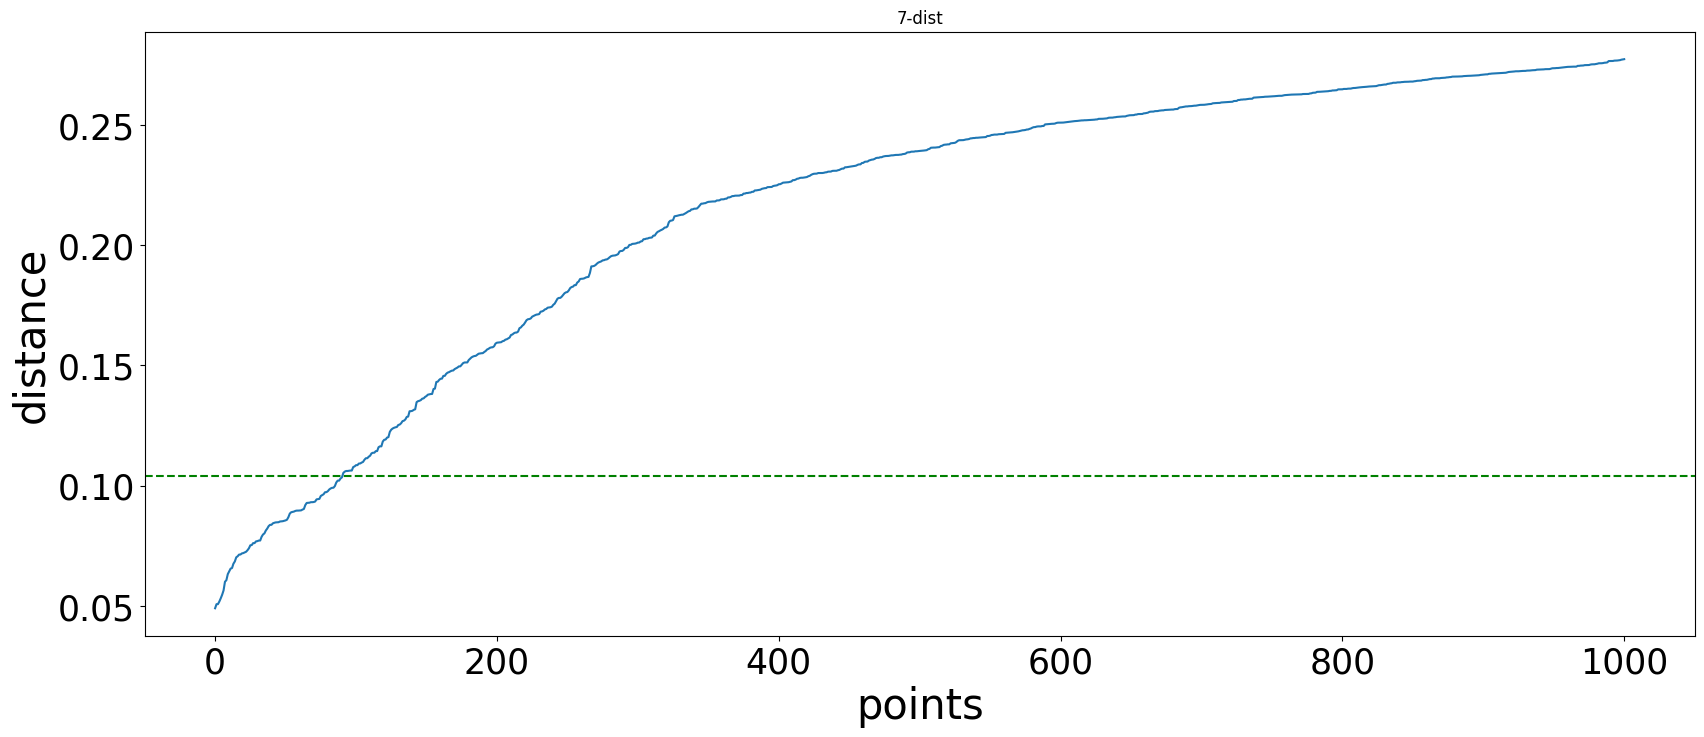

In [21]:
plt.xlabel("points", fontsize=30)
plt.ylabel("distance", fontsize=30)
plt.xticks(fontsize=25)  #fontsize设置x轴和y轴标度的大小
plt.yticks(fontsize=25)
plt.rcParams['figure.figsize'] = (20, 8)
plt.rcParams['figure.dpi'] = 100
plt.axhline(y = 0.104,ls="--",c="green")#添加水平直线
plt.title('7-dist')
plt.plot(k_dist[:1001])
plt.savefig(r"C:\Users\钟冠霆\Desktop\result\border.jpg")
plt.show()

# 确定DBSCAN算法参数 minPts = 8,eps = 0.104

## 使用DBSCAN算法进行聚类分析

In [22]:
y_pred = DBSCAN(eps=0.104,min_samples=8).fit_predict(df)

In [23]:
y_pred[y_pred == 1].shape

(0,)

In [24]:
df

array([[ 0.13135738, -2.04077048, -0.6534969 , -0.05129517,  0.57259671],
       [ 0.26925771, -2.04346964, -0.2361527 ,  0.17983099, -0.02079163],
       [ 0.34777308, -2.04365454,  0.26304905, -0.48961131,  0.21203888],
       ...,
       [-0.48184974,  1.96831549,  0.96693192,  0.50105324,  0.12066931],
       [-0.45277642,  1.97196441, -0.01266795, -0.14248777, -0.91250304],
       [-0.59718387,  1.95520748,  0.05550783, -0.34832201,  0.02717407]])

## 可视化展示

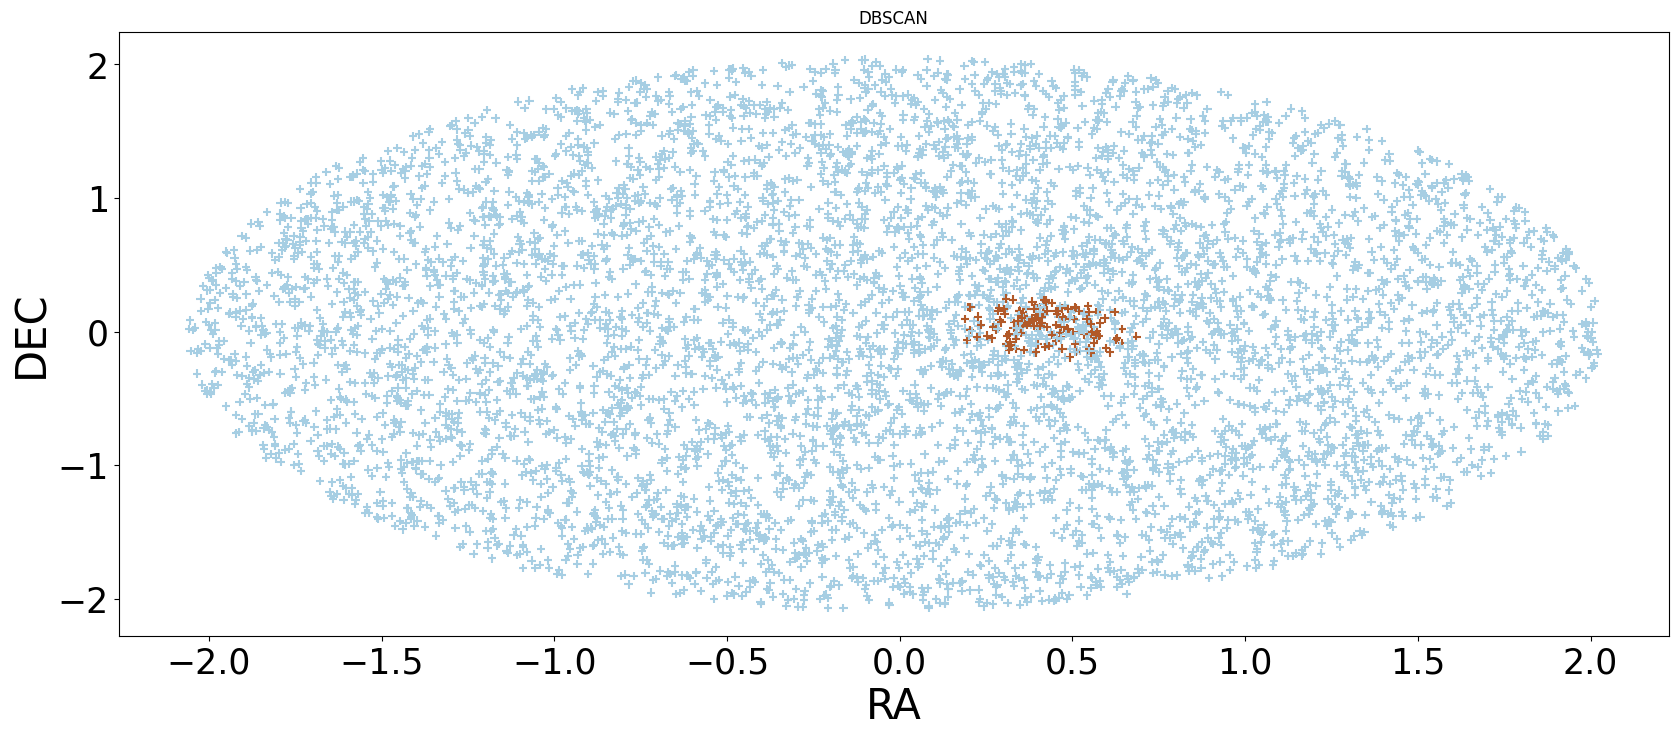

In [25]:
plt.xticks(fontsize=25)  #fontsize设置x轴和y轴标度的大小
plt.yticks(fontsize=25)
plt.xlabel("RA", fontsize=30)
plt.ylabel("DEC", fontsize=30)
plt.rcParams['figure.figsize'] = (20, 8)
plt.rcParams['figure.dpi'] = 100
plt.scatter(x=df[:, 0], y=df[:, 1], c=y_pred,marker='+',cmap='Paired')
# plt.scatter(x=x2[:, -2], y=x2[:, -1], c=y_pred,marker='.',cmap='Paired')
plt.title('DBSCAN')
plt.savefig(r"C:\Users\钟冠霆\Desktop\result\RA_DEC.jpg")
plt.show()